##Training and Evaluating U-Net for Semantic Segmentatio

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("santhoshkumarv/dog-segmentation-dataset")

print("Path to dataset files:", path)

100%|██████████| 5.01M/5.01M [00:00<00:00, 107MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/santhoshkumarv/dog-segmentation-dataset/versions/1


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Paths
base_dir = '/root/.cache/kagglehub/datasets/santhoshkumarv/dog-segmentation-dataset/versions/1'
dataset_dir = os.path.join(base_dir, 'Dog Segmentation')
images = os.path.join(dataset_dir, 'Images')
masks = os.path.join(dataset_dir, 'Labels')


# Resize image size
IMG_SIZE = (224, 224)


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.5586 - loss: 0.6863 - val_accuracy: 0.5262 - val_loss: 0.6890 - learning_rate: 0.0050
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6029 - loss: 0.6679 - val_accuracy: 0.5262 - val_loss: 0.6867 - learning_rate: 0.0050
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6029 - loss: 0.6625 - val_accuracy: 0.5262 - val_loss: 0.6807 - learning_rate: 0.0050
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6029 - loss: 0.6455 - val_accuracy: 0.5262 - val_loss: 0.6525 - learning_rate: 0.0050
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6029 - loss: 0.6227 - val_accuracy: 0.5262 - val_loss: 0.6725 - learning_rate: 0.0050
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6029 - loss: 0.6227 - val_accuracy: 0.5262 - val_loss: 0.6344 - learning_rate: 0.0050
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6025 - loss: 0.5911 - val_acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


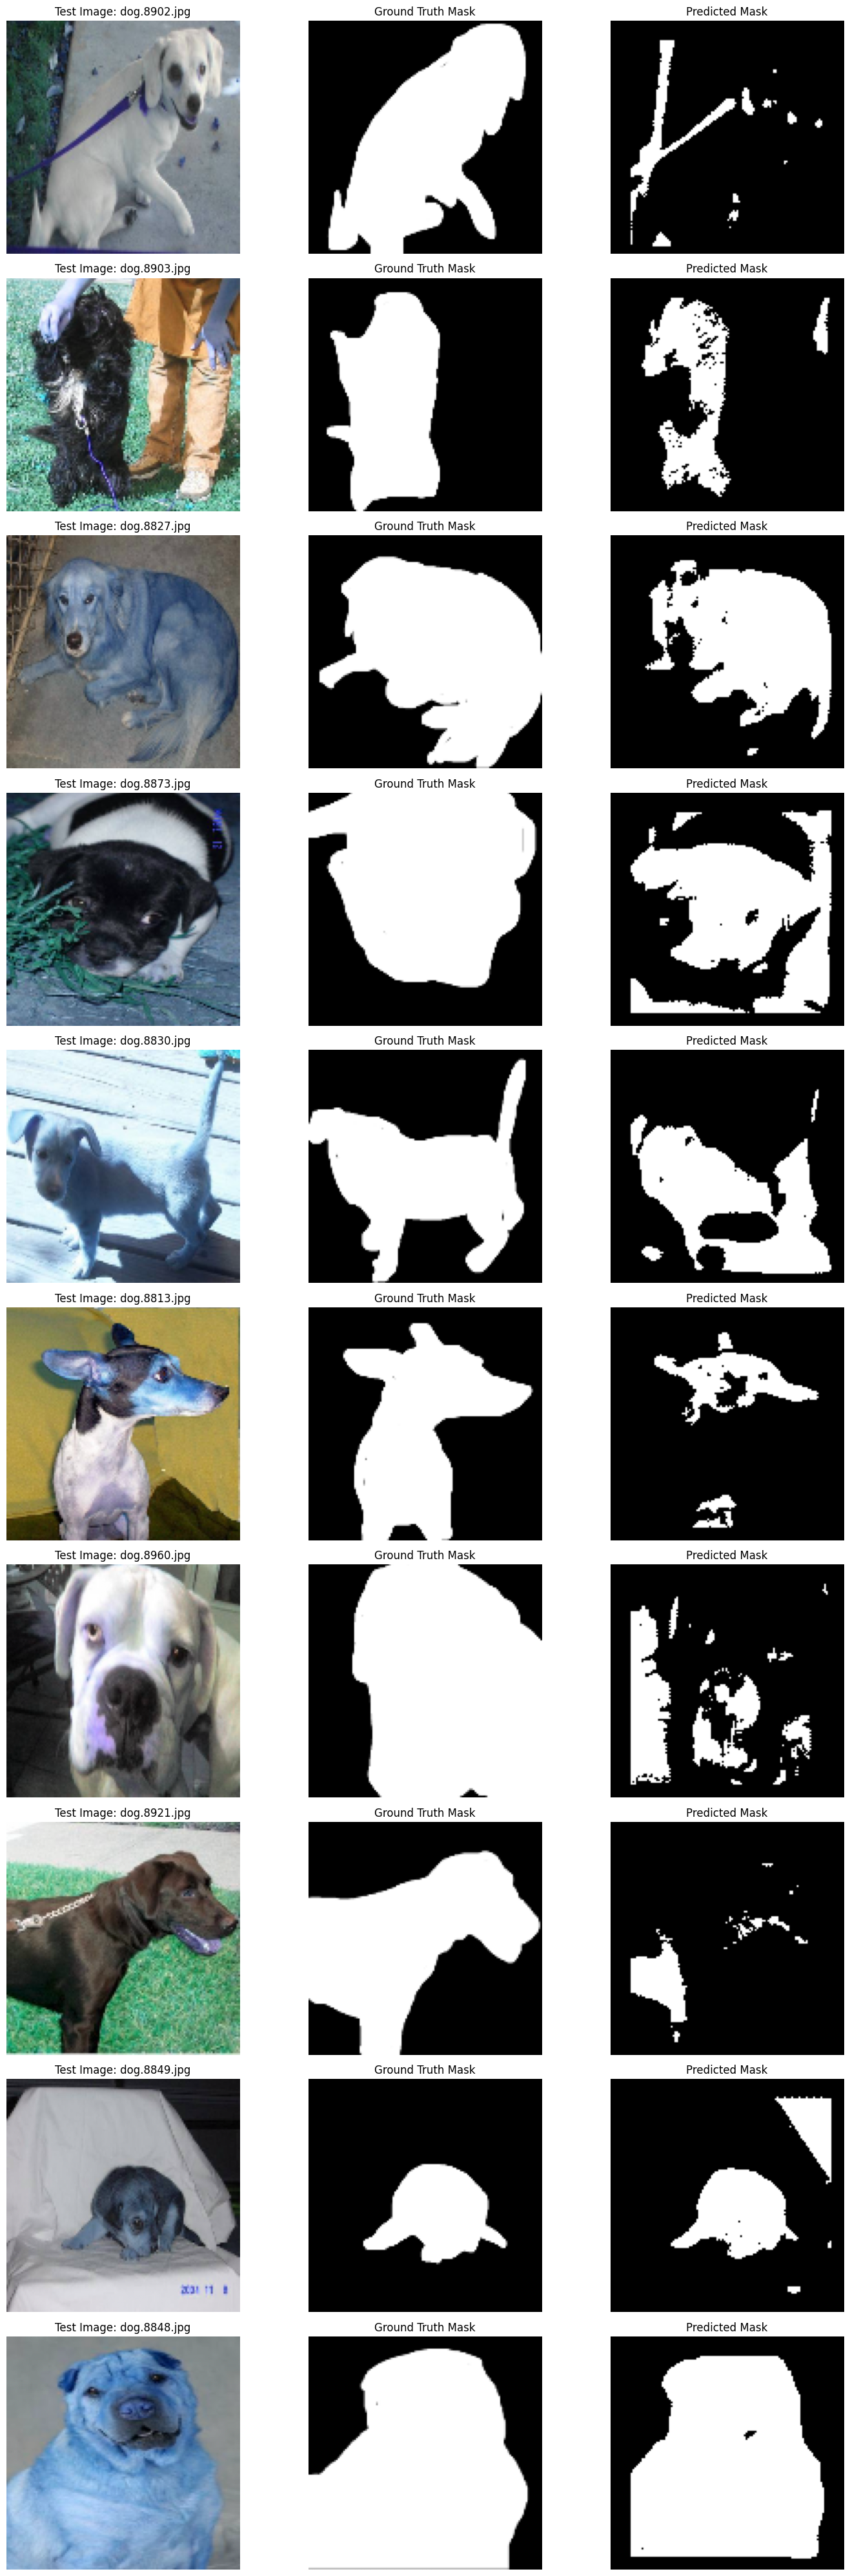

In [ ]:
import cv2
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import random

# Set the seed for reproducibility
def set_seeds(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Data Loading and Preprocessing
def load_and_preprocess_data(image_dir, mask_dir, img_size=(128, 128)):  # Reduced image size
    images = []
    masks = []
    filenames = []

    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, f"annotated_{img_name}")

        if os.path.exists(mask_path):
            # Read and resize image
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize

            # Read and resize mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = mask / 255.0  # Normalize
            mask = np.expand_dims(mask, axis=-1)

            images.append(img)
            masks.append(mask)
            filenames.append(img_name)

    return np.array(images), np.array(masks), filenames

# Minimal U-Net Model Definition
def build_minimal_unet(input_shape=(128, 128, 3)):  # Updated for smaller input size
    inputs = layers.Input(shape=input_shape)

    # Contracting Path (Encoder)
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bridge
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)

    # Expansive Path (Decoder)
    u4 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u4)

    u5 = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Training Function
def train_model(model, X_train, y_train, X_val, y_val, batch_size=8, epochs=10):
    model.compile(
        optimizer=Adam(learning_rate=0.005),  # Adam optimizer
        loss='binary_crossentropy',          # Binary crossentropy loss
        metrics=['accuracy']                 # Accuracy as a metric
    )

    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
        ]
    )
    return history

# Set the seed for reproducibility
set_seeds(seed_value=42)

image_dir = images
mask_dir = masks

# Load and preprocess data
images, masks, filenames = load_and_preprocess_data(image_dir, mask_dir)

# Reserve 10 images for testing
test_size = 10
test_indices = np.random.choice(len(images), test_size, replace=False)

test_images = images[test_indices]
test_masks = masks[test_indices]
test_filenames = [filenames[i] for i in test_indices]

# Remaining for training
train_indices = list(set(range(len(images))) - set(test_indices))
train_images = images[train_indices]
train_masks = masks[train_indices]

with tf.device('/GPU:0'):  # Or '/CPU:0' to force CPU
    model = build_minimal_unet(input_shape=(128, 128, 3))  # Correct input shape

# Train model
history = train_model(model, train_images, train_masks, test_images, test_masks)

# Save the model
model.save('dog_segmentation_model.h5')
predicted_masks = model.predict(test_images)
predicted_masks = (predicted_masks > 0.5).astype(np.uint8)  # Threshold predictions

# Display 10 test images and their corresponding masks
fig, axes = plt.subplots(test_size, 3, figsize=(15, 40))
for i, (img, true_mask, pred_mask, fname) in enumerate(zip(test_images, test_masks, predicted_masks, test_filenames)):
    # Display test image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Test Image: {fname}")
    axes[i, 0].axis('off')

    # Display ground truth mask
    axes[i, 1].imshow(true_mask.squeeze(), cmap='gray')
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis('off')

    # Display predicted mask
    axes[i, 2].imshow(pred_mask.squeeze(), cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


#Training and Evaluating U-Net for Crowd Counting

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tthien/shanghaitech")

print("Path to dataset files:", path)

100%|██████████| 333M/333M [00:06<00:00, 52.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1


In [ ]:
# STEP 1: Imports and Setup
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy.io import loadmat
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# Constants
IMAGE_SIZE = (256, 256)

# Function to generate density map
def generate_density_map(points, shape):
    density = np.zeros(shape, dtype=np.float32)
    for point in points:
        x = min(int(point[0] * shape[1] / shape[1]), shape[1] - 1)
        y = min(int(point[1] * shape[0] / shape[0]), shape[0] - 1)
        density[y, x] += 1
    density = cv2.GaussianBlur(density, (15, 15), 0)
    return density

# Function to load image and .mat file and return image, density map
def load_data(img_paths, gt_paths):
    images, densities = [], []
    for img_path, gt_path in tqdm(zip(img_paths, gt_paths), total=len(img_paths)):
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMAGE_SIZE)
        img = img / 255.0

        mat = loadmat(gt_path)
        points = mat["image_info"][0, 0][0, 0][0]
        density = generate_density_map(points, IMAGE_SIZE)

        images.append(img)
        densities.append(density[..., np.newaxis])
    return np.array(images), np.array(densities)

# Provide correct paths
base_path = "/root/.cache/kagglehub/datasets/tthien/shanghaitech/versions/1/ShanghaiTech/part_A/"


# Train and Test image & gt paths
train_img_paths = sorted(glob(os.path.join(base_path, "train_data/images/*.jpg")))
train_gt_paths  = sorted(glob(os.path.join(base_path, "train_data/ground-truth/*.mat")))

test_img_paths = sorted(glob(os.path.join(base_path, "test_data/images/*.jpg")))
test_gt_paths  = sorted(glob(os.path.join(base_path, "test_data/ground-truth/*.mat")))

# Load data
X_train, Y_train = load_data(train_img_paths, train_gt_paths)
X_test, Y_test   = load_data(test_img_paths, test_gt_paths)
def unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    # Bottleneck
    bn = Conv2D(512, 3, activation='relu', padding='same')(p3)
    bn = Conv2D(512, 3, activation='relu', padding='same')(bn)

    # Decoder
    u3 = UpSampling2D()(bn)
    u3 = concatenate([u3, c3])
    c4 = Conv2D(256, 3, activation='relu', padding='same')(u3)
    c4 = Conv2D(256, 3, activation='relu', padding='same')(c4)

    u2 = UpSampling2D()(c4)
    u2 = concatenate([u2, c2])
    c5 = Conv2D(128, 3, activation='relu', padding='same')(u2)
    c5 = Conv2D(128, 3, activation='relu', padding='same')(c5)

    u1 = UpSampling2D()(c5)
    u1 = concatenate([u1, c1])
    c6 = Conv2D(64, 3, activation='relu', padding='same')(u1)
    c6 = Conv2D(64, 3, activation='relu', padding='same')(c6)

    outputs = Conv2D(1, 1, activation='linear')(c6)

    model = Model(inputs, outputs)
    return model

model = unet((256, 256, 3))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=20,
    batch_size=8,
    callbacks=callbacks
)


100%|██████████| 182/182 [00:01<00:00, 178.57it/s]


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_30[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 128, 128,  │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_32[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 64,    │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_7[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_34[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 32, 32,    │          0 │ conv2d_35[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_8[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_36[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 64, 64,    │          0 │ conv2d_37[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 64, 64,    │          0 │ up_sampling2d_6[… │
│ (Concatenate)       │ 768)              │            │ conv2d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 64, 64,    │  1,769,728 │ concatenate_6[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_38[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_7     │ (None, 128, 128,  │          0 │ conv2d_39[0][0] 

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - loss: 0.0096 - mae: 0.0182 - val_loss: 0.0039 - val_mae: 0.0070
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 408ms/step - loss: 0.0084 - mae: 0.0141 - val_loss: 0.0038 - val_mae: 0.0050
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 414ms/step - loss: 0.0083 - mae: 0.0143 - val_loss: 0.0042 - val_mae: 0.0159
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - loss: 0.0086 - mae: 0.0118 - val_loss: 0.0035 - val_mae: 0.0108
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 401ms/step - loss: 0.0086 - mae: 0.0101 - val_loss: 0.0041 - val_mae: 0.0063
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 400ms/step - loss: 0.0072 - mae: 0.0075 - val_loss: 0.0040 - val_mae: 0.0056
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 407ms/step - loss: 0.0082 - mae: 0.0084 - val_loss: 0.0036 - val_mae: 0.0112
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - loss: 0.0066 - mae: 0.0084 - val_loss: 0.0026 - val_mae: 0.0053
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 402ms/ste

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Choose an index from the test set
index = 0

# Get test image, true density map
test_img = X_test[index]
true_density = Y_test[index]

# Predict density map from the model
pred_density = model.predict(np.expand_dims(test_img, axis=0))[0]

# --- Crowd Count ---
true_count = np.sum(true_density)
pred_count = np.sum(pred_density)

print(f"Ground Truth Count: {true_count:.2f}")
print(f"Predicted Count   : {pred_count:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Ground Truth Count: 64.65
Predicted Count   : 280.04


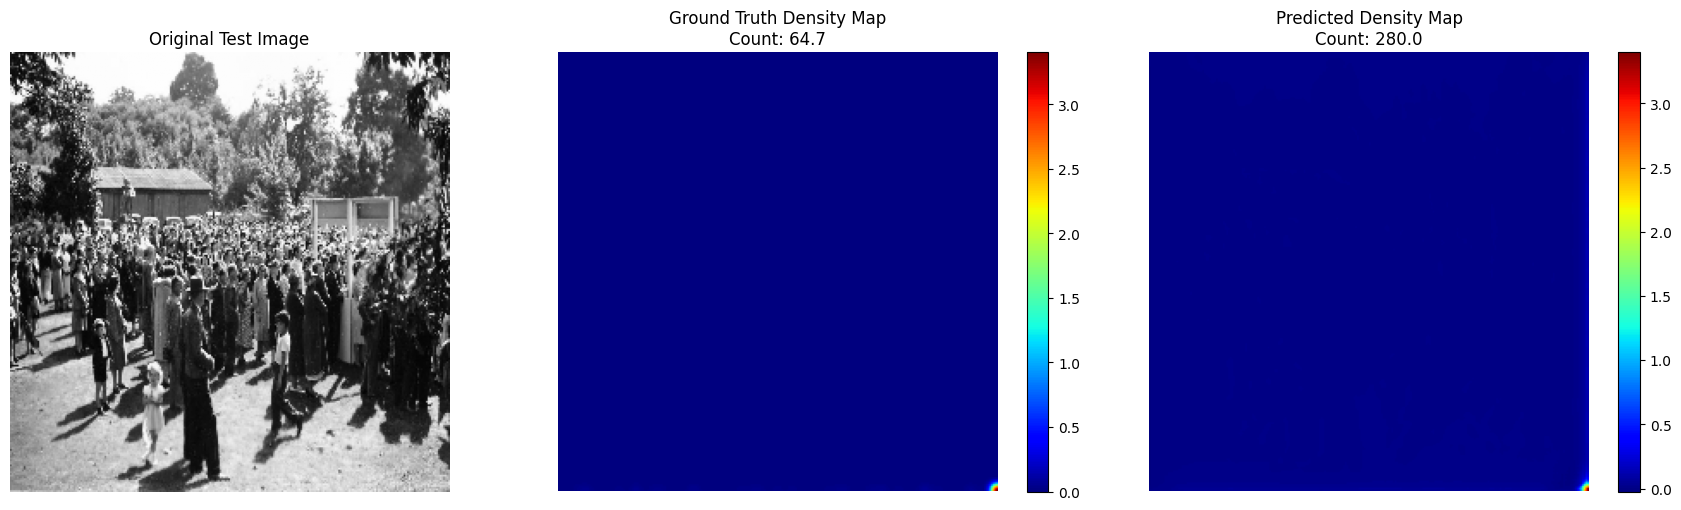

In [ ]:
# Plot input image, ground truth density, and predicted density
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.title("Original Test Image")
plt.imshow(test_img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title(f"Ground Truth Density Map\nCount: {true_count:.1f}")
plt.imshow(true_density[..., 0], cmap='jet')
plt.colorbar()
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Predicted Density Map\nCount: {pred_count:.1f}")
plt.imshow(pred_density[..., 0], cmap='jet')
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()


#Training and Evaluating MCNN for Crowd Counting

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, concatenate
from tensorflow.keras.models import Model

def mcnn_model(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    # Column 1 (large receptive field)
    col1 = Conv2D(16, (9, 9), activation='relu', padding='same')(inputs)
    col1 = Conv2D(32, (7, 7), activation='relu', padding='same')(col1)
    col1 = Conv2D(16, (7, 7), activation='relu', padding='same')(col1)

    # Column 2 (medium receptive field)
    col2 = Conv2D(20, (7, 7), activation='relu', padding='same')(inputs)
    col2 = Conv2D(40, (5, 5), activation='relu', padding='same')(col2)
    col2 = Conv2D(20, (5, 5), activation='relu', padding='same')(col2)

    # Column 3 (small receptive field)
    col3 = Conv2D(24, (5, 5), activation='relu', padding='same')(inputs)
    col3 = Conv2D(48, (3, 3), activation='relu', padding='same')(col3)
    col3 = Conv2D(24, (3, 3), activation='relu', padding='same')(col3)

    # Concatenate outputs
    merged = concatenate([col1, col2, col3], axis=-1)
    output = Conv2D(1, (1, 1), activation='linear', padding='same')(merged)

    return Model(inputs, output)

model1 = mcnn_model()
model1.compile(optimizer='adam', loss='mse')
model1.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 256, 256,  │      3,904 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 256, 256,  │      2,960 │ input_layer_3[0]… │
│                     │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 256, 256,  │      1,824 │ input_layer_3[0]… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 256, 256,  │     25,120 │ conv2d_45[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 256, 256,  │     20,040 │ conv2d_48[0][0]   │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 256, 256,  │     10,416 │ conv2d_51[0][0]   │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 256, 256,  │     25,104 │ conv2d_46[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 256, 256,  │     20,020 │ conv2d_49[0][0]   │
│                     │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 256, 256,  │     10,392 │ conv2d_52[0][0]   │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 256, 256,  │          0 │ conv2d_47[0][0],  │
│ (Concatenate)       │ 60)               │            │ conv2d_50[0][0],  │
│                     │                   │            │ conv2d_53[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 256, 256,  │         61 │ concatenate_9[0]… │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 119,841 (468.13 KB)

 Trainable params: 119,841 (468.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Assuming you have X_train, Y_train, X_test, Y_test prepared
history1 = model1.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=8,
    validation_data=(X_test, Y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 634ms/step - loss: 0.0267 - val_loss: 0.0042
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 0.0130 - val_loss: 0.0041
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0074 - val_loss: 0.0041
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - loss: 0.0066 - val_loss: 0.0040
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - loss: 0.0076 - val_loss: 0.0038
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - loss: 0.0072 - val_loss: 0.0039
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - loss: 0.0054 - val_loss: 0.0041
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - loss: 0.0071 - val_loss: 0.0031
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 0.0074 - val_loss: 0.0031
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 0.0055 - val_loss: 0.0030
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - loss: 0.0055 - val_loss: 0.0034
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Ground Truth Count: 64.65
Predicted Count:    356.70


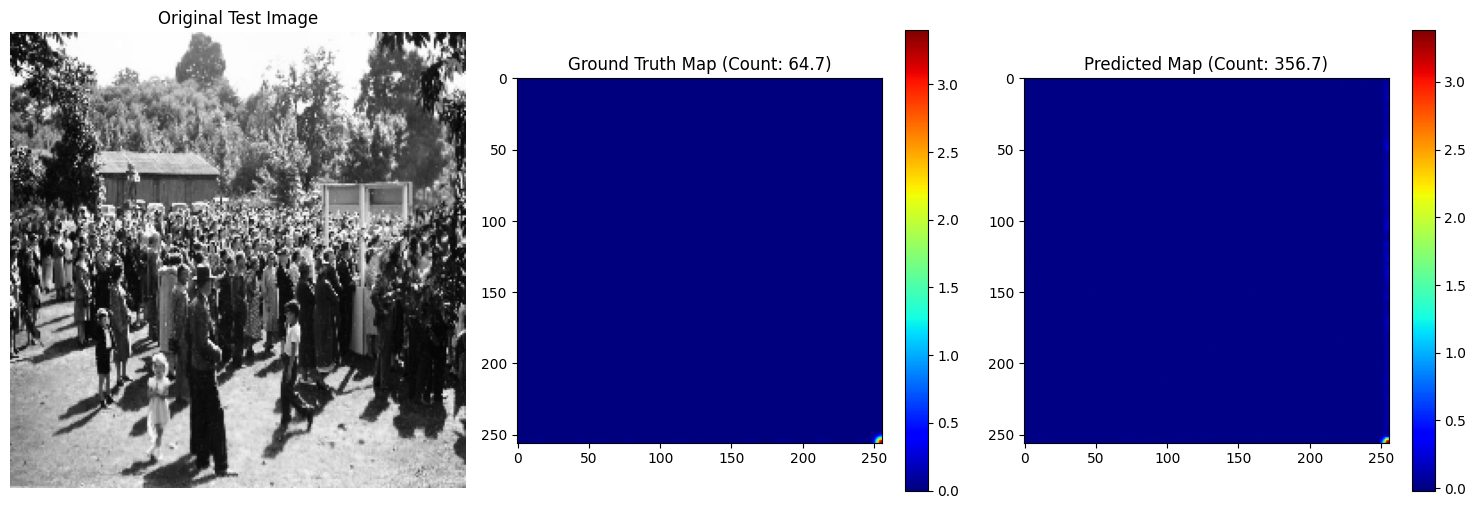

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pick an index from test set
index = 0
test_img = X_test[index]
gt_density = Y_test[index]

# Predict density map
pred_density = model1.predict(np.expand_dims(test_img, axis=0))[0]

# Count
gt_count = np.sum(gt_density)
pred_count = np.sum(pred_density)

print(f"Ground Truth Count: {gt_count:.2f}")
print(f"Predicted Count:    {pred_count:.2f}")

# Visualize
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Test Image")
plt.imshow(test_img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"Ground Truth Map (Count: {gt_count:.1f})")
plt.imshow(gt_density[..., 0], cmap='jet')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title(f"Predicted Map (Count: {pred_count:.1f})")
plt.imshow(pred_density[..., 0], cmap='jet')
plt.colorbar()

plt.tight_layout()
plt.show()


#Comparing U-Net and MCNN for Crowd Counting

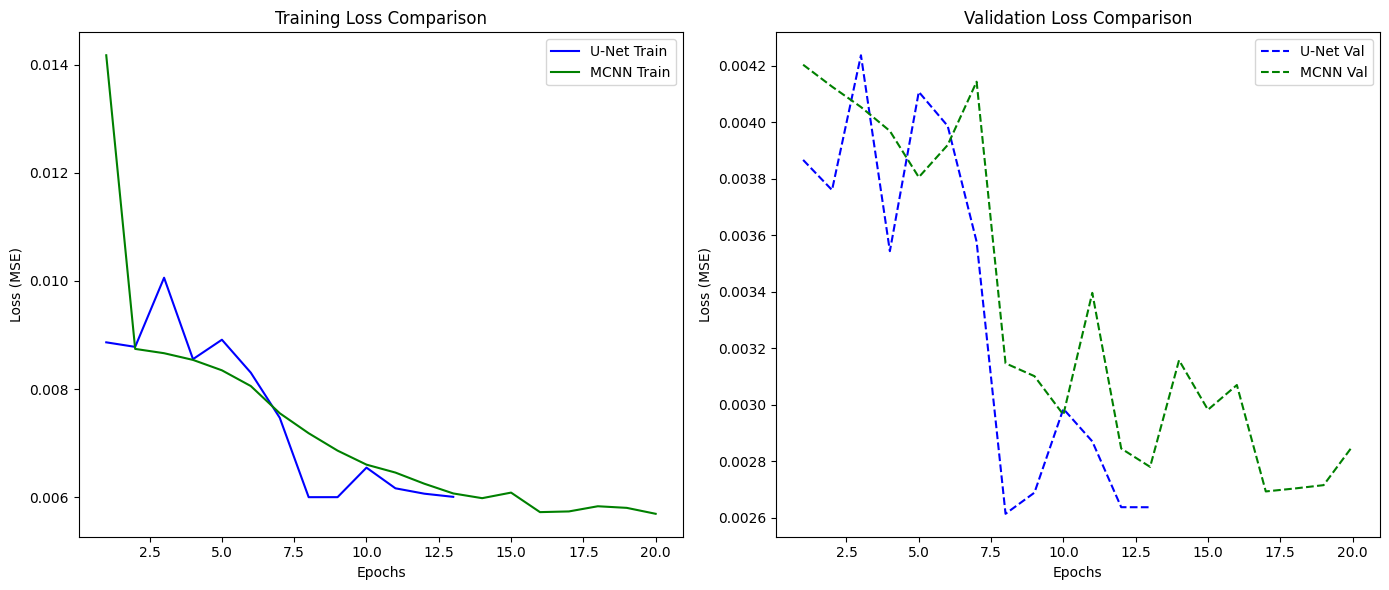

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation loss
unet_train_loss = history.history['loss']
unet_val_loss   = history.history['val_loss']

mcnn_train_loss = history1.history['loss']
mcnn_val_loss   = history1.history['val_loss']

epochs_unet = range(1, len(unet_train_loss) + 1)
epochs_mcnn = range(1, len(mcnn_train_loss) + 1)

plt.figure(figsize=(14, 6))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_unet, unet_train_loss, 'b-', label='U-Net Train')
plt.plot(epochs_mcnn, mcnn_train_loss, 'g-', label='MCNN Train')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

# Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_unet, unet_val_loss, 'b--', label='U-Net Val')
plt.plot(epochs_mcnn, mcnn_val_loss, 'g--', label='MCNN Val')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.tight_layout()
plt.show()
